# Train with CNN

In [78]:
pip install torchcsprng==0.1.3+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1.6 MB 198 kB/s 
     |████████████████████████████████| 577.3 MB 1.3 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.7.0+cu92 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.0+cu92 which is incompatible.


In [3]:
pip install opacus

     |████████████████████████████████| 114 kB 12.3 MB/s 


In [129]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from torch.autograd import Variable
import torch.optim.lr_scheduler
import torch.optim as optim


In [2]:
batch_size = 128

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((64, 64)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(64, 64), interpolation=bilinear)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [4]:
classes = tuple(trainset.classes)
classes

('airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

In [5]:
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # get some random training images
# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join('%11s' % classes[labels[j]] for j in range(4)))

In [6]:
trainset[0][0].size()

torch.Size([3, 64, 64])

Neural Network

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, 
                  out_channels=64, 
                  kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.drop_out = nn.Dropout(0.1)
    self.fc1 = nn.Linear(13 * 13 * 64, 128)
    self.output = nn.Linear(128, 10)


  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.reshape(x.size(0), -1)
    x = self.drop_out(x)
    x = self.fc1(x)
    x = self.output(x)

    return x

In [9]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, 
                  out_channels=64, 
                  kernel_size=5,
                  padding=2),
        nn.ReLU(),
        nn.MaxPool2d(3, 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(3, 2)
    )
    self.drop_out = nn.Dropout(0.5)
    self.fc1 = nn.Linear(15 * 15 * 64, 128)
    self.softmax = nn.Softmax(dim=1)
    self.output = nn.Linear(128, 10)


  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.reshape(x.size(0), -1)
    x = self.drop_out(x)
    x = self.fc1(x)
    x = self.softmax(x)
    x = self.output(x)
    return x

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = CNN().to(device)
device

device(type='cuda', index=0)

In [11]:
net.parameters

<bound method Module.parameters of CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=14400, out_features=128, bias=True)
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=128, out_features=10, bias=True)
)>

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum =0.9)


In [10]:
num_epochs = 30

total_step = len(trainloader)
for epoch in range(num_epochs):
  for i, (inputs, labels) in enumerate(trainloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = net(inputs) # forward pass
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward() # backward pass
    optimizer.step() # gradient descent

    if (i+1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: [{loss.item():.6f}]')


print('Finished Training!')

Epoch [1/30], Step [100/391], Loss: [2.302115]
Epoch [1/30], Step [200/391], Loss: [2.301712]
Epoch [1/30], Step [300/391], Loss: [2.300704]
Epoch [2/30], Step [100/391], Loss: [2.301600]
Epoch [2/30], Step [200/391], Loss: [2.292965]
Epoch [2/30], Step [300/391], Loss: [2.240517]


KeyboardInterrupt: 

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for (images,labels) in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        
        numbers,predicted = torch.max(outputs.data,1)
        total +=labels.size(0)
        correct+=(predicted==labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 19 %


In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 63 %
Accuracy of automobile : 87 %
Accuracy of  bird : 68 %
Accuracy of   cat : 12 %
Accuracy of  deer : 56 %
Accuracy of   dog : 14 %
Accuracy of  frog : 29 %
Accuracy of horse : 51 %
Accuracy of  ship : 76 %
Accuracy of truck : 10 %


In [22]:
cd /content/drive/MyDrive/master

/content/drive/MyDrive/master


In [24]:
PATH = './cifar_net_no Noise.pth'
torch.save(net.state_dict(), PATH)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


add noise to hidden layer

In [12]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, 
                  out_channels=64, 
                  kernel_size=5,
                  padding=2),
        nn.ReLU(),
        nn.MaxPool2d(3, 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(3, 2)
    )
    self.drop_out = nn.Dropout(0.5)
    self.fc1 = nn.Linear(15 * 15 * 64, 128)
    self.softmax = nn.Softmax(dim=1)
    self.output = nn.Linear(128, 10)


  def forward(self, x, eps=0.5):
    x = self.layer1(x)
    if self.training:
      shape = x.size()
      noise =torch.cuda.FloatTensor(shape) if torch.cuda.is_available()else torch.FloatTensor(shape)
      torch.randn(shape,out = noise)
      x = x + noise * eps
    x = self.layer2(x)
    x = x.reshape(x.size(0), -1)
    x = self.drop_out(x)
    x = self.fc1(x)

    # add some noies
    # if self.training:
    #   shape = x.size()
    #   noise =torch.cuda.FloatTensor(shape) if torch.cuda.is_available()else torch.FloatTensor(shape)
    #   torch.randn(shape,out = noise)
    #   x = x + noise * eps
    x = self.softmax(x)
    x = self.output(x)
    return x

In [13]:
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# privacy_engine = PrivacyEngine(
#     model,
#     sample_rate=0.01,
#     alphas=[10, 100],
#     noise_multiplier=1.3,
#     max_grad_norm=1.0,
# )
# privacy_engine.attach(optimizer)


In [29]:

num_epochs = 30

total_step = len(trainloader)
for epoch in range(num_epochs):
  for i, (inputs, labels) in enumerate(trainloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = net(inputs) # forward pass
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward() # backward pass
    optimizer.step() # gradient descent

    if (i+1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: [{loss.item():.6f}]')


print('Finished Training!')

Epoch [1/30], Step [100/391], Loss: [2.302696]
Epoch [1/30], Step [200/391], Loss: [2.300767]
Epoch [1/30], Step [300/391], Loss: [2.267286]
Epoch [2/30], Step [100/391], Loss: [2.137478]
Epoch [2/30], Step [200/391], Loss: [2.028255]
Epoch [2/30], Step [300/391], Loss: [2.056444]
Epoch [3/30], Step [100/391], Loss: [1.974549]
Epoch [3/30], Step [200/391], Loss: [1.945884]
Epoch [3/30], Step [300/391], Loss: [1.851579]
Epoch [4/30], Step [100/391], Loss: [1.835298]
Epoch [4/30], Step [200/391], Loss: [1.827409]
Epoch [4/30], Step [300/391], Loss: [1.679700]
Epoch [5/30], Step [100/391], Loss: [1.773584]
Epoch [5/30], Step [200/391], Loss: [1.725947]
Epoch [5/30], Step [300/391], Loss: [1.869470]
Epoch [6/30], Step [100/391], Loss: [1.829937]
Epoch [6/30], Step [200/391], Loss: [1.792111]
Epoch [6/30], Step [300/391], Loss: [1.710975]
Epoch [7/30], Step [100/391], Loss: [1.745561]
Epoch [7/30], Step [200/391], Loss: [1.715815]
Epoch [7/30], Step [300/391], Loss: [1.867015]
Epoch [8/30],

In [30]:
# evaluation
correct = 0
total = 0
with torch.no_grad():
    for (images,labels) in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        
        numbers,predicted = torch.max(outputs.data,1)
        total +=labels.size(0)
        correct+=(predicted==labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 42 %


In [31]:

PATH = './CNN_with_0.5noise_head_42.pth'
torch.save(net.state_dict(), PATH)

# Resnet18 without noise

In [13]:
from torch.utils.data import random_split, RandomSampler, Subset

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

batch_size = 128

torch.manual_seed(43)
val_size = 5000
train_size = len(trainset) - val_size

train_size, val_size

Files already downloaded and verified
Files already downloaded and verified


(45000, 5000)

In [15]:
train_set, val_set = random_split(trainset, [train_size, val_size])
len(train_set), len(val_set)

(45000, 5000)

In [16]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

len(trainloader), len(valloader), len(testloader)

(352, 40, 79)

In [17]:
image_datasets = {'train': train_set, 'val': val_set}

dataloaders = {'train': trainloader, 'val': valloader}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = train_set.dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [122]:
dataset_sizes, class_names

({'train': 45000, 'val': 5000},
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [123]:
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# imshow(torchvision.utils.make_grid(images[:5]))
# print(list(class_names[x] for x in labels[:5]))

In [124]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_fc = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [125]:
import time
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [126]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.6966 Acc: 0.3834
val Loss: 1.4813 Acc: 0.4636

Epoch 1/9
----------
train Loss: 1.3203 Acc: 0.5228
val Loss: 1.3073 Acc: 0.5306

Epoch 2/9
----------
train Loss: 1.1273 Acc: 0.5954
val Loss: 1.2572 Acc: 0.5506

Epoch 3/9
----------
train Loss: 0.9672 Acc: 0.6563
val Loss: 1.2385 Acc: 0.5690

Epoch 4/9
----------
train Loss: 0.8190 Acc: 0.7115
val Loss: 1.2391 Acc: 0.5790

Epoch 5/9
----------
train Loss: 0.6719 Acc: 0.7664
val Loss: 1.2683 Acc: 0.5726

Epoch 6/9
----------
train Loss: 0.5419 Acc: 0.8144
val Loss: 1.3163 Acc: 0.5832

Epoch 7/9
----------
train Loss: 0.3147 Acc: 0.9113
val Loss: 1.2780 Acc: 0.5992

Epoch 8/9
----------
train Loss: 0.2485 Acc: 0.9372
val Loss: 1.3006 Acc: 0.5992

Epoch 9/9
----------
train Loss: 0.2142 Acc: 0.9509
val Loss: 1.3177 Acc: 0.5988

Training complete in 3m 34s
Best val Acc: 0.599200


In [ ]:
PATH = './resnet_without_noise_62.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        # if use_gpu:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        # else:
        #     inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

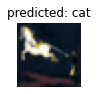

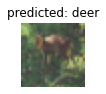

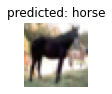

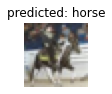

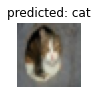

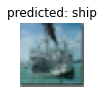

In [ ]:
# visualize_model(model_ft)

In [48]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy of the model on the {len(testset)} test images: {100 * correct / total} %')


Test Accuracy of the model on the 10000 test images: 60.59 %


rest net with noise(to all layer)

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,eps=0.1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        # add some noise to all layer#######################################
                        grads = (p.grad for p in model.parameters())
                        for p in model.parameters():
                          noise = torch.empty(p.shape).normal_(mean=0,std=1).to(device)
                          p.grad.data+= noise*eps  ###############################

                          p.data = p.data - 0.001* p.grad.data
                          p.grad.data.zero_()


                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [35]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_fc = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [36]:
torch.empty(5).normal_(mean=4,std=0.5)

tensor([4.3263, 4.5242, 3.9759, 3.1281, 3.4529])

In [37]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10,eps=0.1)

Epoch 0/9
----------
train Loss: 2.0989 Acc: 0.2417
val Loss: 1.8811 Acc: 0.3200

Epoch 1/9
----------
train Loss: 1.7388 Acc: 0.3658
val Loss: 1.6873 Acc: 0.3832

Epoch 2/9
----------
train Loss: 1.5919 Acc: 0.4193
val Loss: 1.5809 Acc: 0.4198

Epoch 3/9
----------
train Loss: 1.4996 Acc: 0.4528
val Loss: 1.5290 Acc: 0.4338

Epoch 4/9
----------
train Loss: 1.4294 Acc: 0.4827
val Loss: 1.4822 Acc: 0.4558

Epoch 5/9
----------
train Loss: 1.3702 Acc: 0.5069
val Loss: 1.4467 Acc: 0.4726

Epoch 6/9
----------
train Loss: 1.3222 Acc: 0.5228
val Loss: 1.4198 Acc: 0.4922

Epoch 7/9
----------
train Loss: 1.2795 Acc: 0.5424
val Loss: 1.3943 Acc: 0.4886

Epoch 8/9
----------
train Loss: 1.2407 Acc: 0.5554
val Loss: 1.3770 Acc: 0.5020

Epoch 9/9
----------
train Loss: 1.2040 Acc: 0.5738
val Loss: 1.3601 Acc: 0.5026

Training complete in 8m 44s
Best val Acc: 0.502600


In [42]:
for a, b in model_ft.named_parameters():
    print(a)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

# add noise after convolution

In [109]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
    
    
    # eps is noise multiplier
    def forward(self, x,eps=0.6):
        identity = x

        out = self.conv1(x)
        # add noise after convolution#############################################
        if self.training:
            shape = out.size()
            noise =torch.cuda.FloatTensor(shape) if torch.cuda.is_available() else torch.FloatTensor(shape)
            torch.randn(shape,out = noise)
            out = out + noise * eps
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        # add noise after convolution#############################################
        if self.training:
            shape = out.size()
            noise =torch.cuda.FloatTensor(shape) if torch.cuda.is_available() else torch.FloatTensor(shape)
            torch.randn(shape,out = noise)
            out = out + noise * eps
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None ,num_classes=10):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512 * block.expansion, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

def resnet18New(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model



In [110]:
# def test():
#     net = resnet18New(num_classes=10)
#     x = net(Variable(torch.randn(20,3,224,224)))
#     print('X :', x.size())
# test()

In [111]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [112]:
model_ft = resnet18New(num_classes=10)
# num_ftrs = model_ft.fc.in_features

# model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_fc = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [108]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10) # eps = 0.8

Epoch 0/9
----------
train Loss: 2.3824 Acc: 0.1147
val Loss: 2.1884 Acc: 0.1572

Epoch 1/9
----------
train Loss: 2.1720 Acc: 0.1762
val Loss: 2.0980 Acc: 0.2072

Epoch 2/9
----------
train Loss: 1.9647 Acc: 0.2308
val Loss: 2.0365 Acc: 0.2424

Epoch 3/9
----------
train Loss: 1.8538 Acc: 0.2689
val Loss: 1.9096 Acc: 0.2828

Epoch 4/9
----------
train Loss: 1.7881 Acc: 0.2960
val Loss: 1.9074 Acc: 0.2912

Epoch 5/9
----------
train Loss: 1.7449 Acc: 0.3168
val Loss: 1.9054 Acc: 0.3118

Epoch 6/9
----------
train Loss: 1.7065 Acc: 0.3303
val Loss: 1.7688 Acc: 0.3550

Epoch 7/9
----------
train Loss: 1.6682 Acc: 0.3472
val Loss: 1.7260 Acc: 0.3584

Epoch 8/9
----------
train Loss: 1.6623 Acc: 0.3506
val Loss: 1.7300 Acc: 0.3576

Epoch 9/9
----------
train Loss: 1.6548 Acc: 0.3541
val Loss: 1.7491 Acc: 0.3570

Training complete in 3m 35s
Best val Acc: 0.358400


In [113]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10) # eps =0.6

Epoch 0/9
----------
train Loss: 2.3049 Acc: 0.1439
val Loss: 2.0922 Acc: 0.2172

Epoch 1/9
----------
train Loss: 1.9420 Acc: 0.2479
val Loss: 1.9356 Acc: 0.2748

Epoch 2/9
----------
train Loss: 1.7827 Acc: 0.3050
val Loss: 1.8226 Acc: 0.3332

Epoch 3/9
----------
train Loss: 1.6979 Acc: 0.3426
val Loss: 1.7044 Acc: 0.3776

Epoch 4/9
----------
train Loss: 1.6236 Acc: 0.3746
val Loss: 1.6351 Acc: 0.4040

Epoch 5/9
----------
train Loss: 1.5621 Acc: 0.4014
val Loss: 1.6238 Acc: 0.4270

Epoch 6/9
----------
train Loss: 1.5026 Acc: 0.4286
val Loss: 1.5790 Acc: 0.4492

Epoch 7/9
----------
train Loss: 1.4431 Acc: 0.4542
val Loss: 1.5577 Acc: 0.4566

Epoch 8/9
----------
train Loss: 1.4345 Acc: 0.4574
val Loss: 1.5521 Acc: 0.4592

Epoch 9/9
----------
train Loss: 1.4255 Acc: 0.4641
val Loss: 1.5289 Acc: 0.4620

Training complete in 3m 36s
Best val Acc: 0.462000


#  add noise after pooling layer

In [119]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
    
    
    # eps is noise multiplier
    def forward(self, x):
        identity = x

        out = self.conv1(x)
#         # add noise after convolution#############################################
#         if self.training:
#             shape = out.size()
#             noise =torch.cuda.FloatTensor(shape) if torch.cuda.is_available() else torch.FloatTensor(shape)
#             torch.randn(shape,out = noise)
#             out = out + noise * eps
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
#         # add noise after convolution#############################################
#         if self.training:
#             shape = out.size()
#             noise =torch.cuda.FloatTensor(shape) if torch.cuda.is_available() else torch.FloatTensor(shape)
#             torch.randn(shape,out = noise)
#             out = out + noise * eps
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None ,num_classes=10):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512 * block.expansion, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x, eps = 0.6):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        if self.training:
            shape = x.size()
            noise =torch.cuda.FloatTensor(shape) if torch.cuda.is_available() else torch.FloatTensor(shape)
            torch.randn(shape,out = noise)
            x = x + noise * eps

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        if self.training:
            shape = x.size()
            noise =torch.cuda.FloatTensor(shape) if torch.cuda.is_available() else torch.FloatTensor(shape)
            torch.randn(shape,out = noise)
            x = x + noise * eps
        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

def resnet18New(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model



In [120]:
model_ft = resnet18New(num_classes=10)
# num_ftrs = model_ft.fc.in_features

# model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_fc = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [118]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10) # eps = 0.8

Epoch 0/9
----------
train Loss: 1.9232 Acc: 0.2976
val Loss: 1.6561 Acc: 0.3974

Epoch 1/9
----------
train Loss: 1.5702 Acc: 0.4241
val Loss: 1.4772 Acc: 0.4728

Epoch 2/9
----------
train Loss: 1.4249 Acc: 0.4772
val Loss: 1.3785 Acc: 0.5042

Epoch 3/9
----------
train Loss: 1.3266 Acc: 0.5209
val Loss: 1.3222 Acc: 0.5318

Epoch 4/9
----------
train Loss: 1.2343 Acc: 0.5548
val Loss: 1.3492 Acc: 0.5366

Epoch 5/9
----------
train Loss: 1.1510 Acc: 0.5868
val Loss: 1.2521 Acc: 0.5658

Epoch 6/9
----------
train Loss: 1.0851 Acc: 0.6119
val Loss: 1.1863 Acc: 0.5852

Epoch 7/9
----------
train Loss: 1.0022 Acc: 0.6420
val Loss: 1.0936 Acc: 0.6130

Epoch 8/9
----------
train Loss: 0.9887 Acc: 0.6476
val Loss: 1.0762 Acc: 0.6182

Epoch 9/9
----------
train Loss: 0.9771 Acc: 0.6534
val Loss: 1.0730 Acc: 0.6168

Training complete in 3m 35s
Best val Acc: 0.618200


In [121]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10) # eps = 0.6

Epoch 0/9
----------
train Loss: 1.8359 Acc: 0.3254
val Loss: 1.5458 Acc: 0.4364

Epoch 1/9
----------
train Loss: 1.4824 Acc: 0.4580
val Loss: 1.3669 Acc: 0.5016

Epoch 2/9
----------
train Loss: 1.3415 Acc: 0.5136
val Loss: 1.2616 Acc: 0.5412

Epoch 3/9
----------
train Loss: 1.2342 Acc: 0.5526
val Loss: 1.2183 Acc: 0.5640

Epoch 4/9
----------
train Loss: 1.1440 Acc: 0.5873
val Loss: 1.1625 Acc: 0.5880

Epoch 5/9
----------
train Loss: 1.0656 Acc: 0.6173
val Loss: 1.1419 Acc: 0.6008

Epoch 6/9
----------
train Loss: 0.9894 Acc: 0.6453
val Loss: 1.0629 Acc: 0.6272

Epoch 7/9
----------
train Loss: 0.8981 Acc: 0.6800
val Loss: 1.0321 Acc: 0.6376

Epoch 8/9
----------
train Loss: 0.8855 Acc: 0.6855
val Loss: 1.0142 Acc: 0.6422

Epoch 9/9
----------
train Loss: 0.8706 Acc: 0.6889
val Loss: 1.0111 Acc: 0.6472

Training complete in 3m 34s
Best val Acc: 0.647200


# shufflenet without noise

In [132]:
model_ft = models.shufflenet_v2_x1_0(pretrained=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_fc = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [133]:
import time
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [135]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.0632 Acc: 0.6232
val Loss: 1.3673 Acc: 0.5088

Epoch 1/9
----------
train Loss: 1.0409 Acc: 0.6320
val Loss: 1.3743 Acc: 0.5080

Epoch 2/9
----------
train Loss: 1.0240 Acc: 0.6381
val Loss: 1.3820 Acc: 0.5074

Epoch 3/9
----------
train Loss: 1.0052 Acc: 0.6435
val Loss: 1.3767 Acc: 0.5112

Epoch 4/9
----------
train Loss: 0.9823 Acc: 0.6557
val Loss: 1.3816 Acc: 0.5082

Epoch 5/9
----------
train Loss: 0.9800 Acc: 0.6575
val Loss: 1.3843 Acc: 0.5092

Epoch 6/9
----------
train Loss: 0.9775 Acc: 0.6594
val Loss: 1.3822 Acc: 0.5120

Epoch 7/9
----------
train Loss: 0.9752 Acc: 0.6595
val Loss: 1.3777 Acc: 0.5122

Epoch 8/9
----------
train Loss: 0.9753 Acc: 0.6583
val Loss: 1.3846 Acc: 0.5102

Epoch 9/9
----------
train Loss: 0.9716 Acc: 0.6593
val Loss: 1.3887 Acc: 0.5066

Training complete in 3m 12s
Best val Acc: 0.512200


In [ ]:
def channel_shuffle(x: Tensor, groups: int) -> Tensor:
    batchsize, num_channels, height, width = x.size()
    channels_per_group = num_channels // groups

    # reshape
    x = x.view(batchsize, groups, channels_per_group, height, width)

    x = torch.transpose(x, 1, 2).contiguous()

    # flatten
    x = x.view(batchsize, -1, height, width)

    return x


class InvertedResidual(nn.Module):
    def __init__(self, inp: int, oup: int, stride: int) -> None:
        super().__init__()

        if not (1 <= stride <= 3):
            raise ValueError("illegal stride value")
        self.stride = stride

        branch_features = oup // 2
        assert (self.stride != 1) or (inp == branch_features << 1)

        if self.stride > 1:
            self.branch1 = nn.Sequential(
                self.depthwise_conv(inp, inp, kernel_size=3, stride=self.stride, padding=1),
                nn.BatchNorm2d(inp),
                nn.Conv2d(inp, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(branch_features),
                nn.ReLU(inplace=True),
            )
        else:
            self.branch1 = nn.Sequential()

        self.branch2 = nn.Sequential(
            nn.Conv2d(
                inp if (self.stride > 1) else branch_features,
                branch_features,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True),
            self.depthwise_conv(branch_features, branch_features, kernel_size=3, stride=self.stride, padding=1),
            nn.BatchNorm2d(branch_features),
            nn.Conv2d(branch_features, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True),
        )

    @staticmethod
    def depthwise_conv(
        i: int, o: int, kernel_size: int, stride: int = 1, padding: int = 0, bias: bool = False
    ) -> nn.Conv2d:
        return nn.Conv2d(i, o, kernel_size, stride, padding, bias=bias, groups=i)

    def forward(self, x: Tensor) -> Tensor:
        if self.stride == 1:
            x1, x2 = x.chunk(2, dim=1)
            out = torch.cat((x1, self.branch2(x2)), dim=1)
        else:
            out = torch.cat((self.branch1(x), self.branch2(x)), dim=1)

        out = channel_shuffle(out, 2)

        return out


class ShuffleNetV2(nn.Module):
    def __init__(
        self,
        stages_repeats: List[int],
        stages_out_channels: List[int],
        num_classes: int = 1000,
        inverted_residual: Callable[..., nn.Module] = InvertedResidual,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)

        if len(stages_repeats) != 3:
            raise ValueError("expected stages_repeats as list of 3 positive ints")
        if len(stages_out_channels) != 5:
            raise ValueError("expected stages_out_channels as list of 5 positive ints")
        self._stage_out_channels = stages_out_channels

        input_channels = 3
        output_channels = self._stage_out_channels[0]
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3, 2, 1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )
        input_channels = output_channels

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Static annotations for mypy
        self.stage2: nn.Sequential
        self.stage3: nn.Sequential
        self.stage4: nn.Sequential
        stage_names = [f"stage{i}" for i in [2, 3, 4]]
        for name, repeats, output_channels in zip(stage_names, stages_repeats, self._stage_out_channels[1:]):
            seq = [inverted_residual(input_channels, output_channels, 2)]
            for i in range(repeats - 1):
                seq.append(inverted_residual(output_channels, output_channels, 1))
            setattr(self, name, nn.Sequential(*seq))
            input_channels = output_channels

        output_channels = self._stage_out_channels[-1]
        self.conv5 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )

        self.fc = nn.Linear(output_channels, num_classes)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.conv5(x)
        x = x.mean([2, 3])  # globalpool
        x = self.fc(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _shufflenetv2(arch: str, pretrained: bool, progress: bool, *args: Any, **kwargs: Any) -> ShuffleNetV2:
    model = ShuffleNetV2(*args, **kwargs)

    if pretrained:
        model_url = model_urls[arch]
        if model_url is None:
            raise ValueError(f"No checkpoint is available for model type {arch}")
        else:
            state_dict = load_state_dict_from_url(model_url, progress=progress)
            model.load_state_dict(state_dict)

    return model


def shufflenet_v2_x0_5(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ShuffleNetV2:
    """
    Constructs a ShuffleNetV2 with 0.5x output channels, as described in
    `"ShuffleNet V2: Practical Guidelines for Efficient CNN Architecture Design"
    <https://arxiv.org/abs/1807.11164>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _shufflenetv2("shufflenetv2_x0.5", pretrained, progress, [4, 8, 4], [24, 48, 96, 192, 1024], **kwargs)


def shufflenet_v2_x1_0(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ShuffleNetV2:
    """
    Constructs a ShuffleNetV2 with 1.0x output channels, as described in
    `"ShuffleNet V2: Practical Guidelines for Efficient CNN Architecture Design"
    <https://arxiv.org/abs/1807.11164>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _shufflenetv2("shufflenetv2_x1.0", pretrained, progress, [4, 8, 4], [24, 116, 232, 464, 1024], **kwargs)

Pretrained Network (Bees & Ants)

In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2021-11-10 11:22:06--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.84.225.122, 52.84.225.58, 52.84.225.92, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.84.225.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  46.5MB/s    in 1.0s    

2021-11-10 11:22:07 (46.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

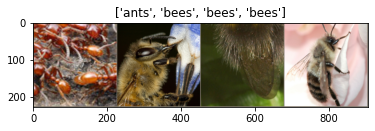

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # img = img / 2 + 0.5     # unnormalize
    # npimg = img.numpy()
    # plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            
            titles=[class_names[x] for x in labels]
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, correct: {}'.format(class_names[preds[j]], class_names[preds[j]] == titles[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_fc = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8806 Acc: 0.4959
val Loss: 1.7609 Acc: 0.5425

Epoch 1/24
----------
train Loss: 0.8768 Acc: 0.5123
val Loss: 1.1880 Acc: 0.5425

Epoch 2/24
----------
train Loss: 0.7678 Acc: 0.5861
val Loss: 0.9069 Acc: 0.5359

Epoch 3/24
----------
train Loss: 0.7302 Acc: 0.5697
val Loss: 0.8138 Acc: 0.5686

Epoch 4/24
----------
train Loss: 0.7865 Acc: 0.6025
val Loss: 1.1314 Acc: 0.5359

Epoch 5/24
----------
train Loss: 0.7295 Acc: 0.5861
val Loss: 0.6680 Acc: 0.6471

Epoch 6/24
----------
train Loss: 0.6710 Acc: 0.6475
val Loss: 0.7885 Acc: 0.6536

Epoch 7/24
----------
train Loss: 0.6277 Acc: 0.6516
val Loss: 0.7162 Acc: 0.6732

Epoch 8/24
----------
train Loss: 0.6193 Acc: 0.6598
val Loss: 0.6931 Acc: 0.7059

Epoch 9/24
----------
train Loss: 0.6198 Acc: 0.6434
val Loss: 0.6463 Acc: 0.7059

Epoch 10/24
----------
train Loss: 0.5999 Acc: 0.6639
val Loss: 0.6394 Acc: 0.6928

Epoch 11/24
----------
train Loss: 0.5719 Acc: 0.7049
val Loss: 0.6633 Acc: 0.6797

Ep

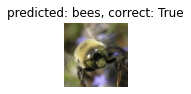

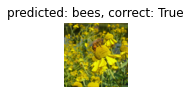

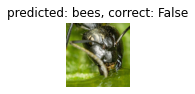

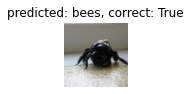

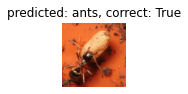

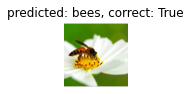

In [ ]:
visualize_model(model_ft)

# Layer & Channels

In [ ]:
import torch
 
in_channels = 3  #输入通道数量
out_channels =64 #输出通道数量
width = 64      #每个输入通道上的卷积尺寸的宽
heigth = 64     #每个输入通道上的卷积尺寸的高
kernel_size = 5  #每个输入通道上的卷积尺寸
batch_size = 128   #批数量
 
input = torch.randn(batch_size,in_channels,width,heigth)
conv_layer = torch.nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size)
 
out_put = conv_layer(input)
 
print(input.shape)      # batch_size, in_channels, width, height
print(out_put.shape)    # batch_size, out_channels, width, height
print(conv_layer.weight.shape) # out_channels, in_channels, kernel_size, kernel_size

torch.Size([128, 3, 64, 64])
torch.Size([128, 64, 60, 60])
torch.Size([64, 3, 5, 5])


In [ ]:
# layer 1
input = torch.randn(batch_size,in_channels,width,heigth)
conv_layer = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
pool = torch.nn.MaxPool2d(2, 2)
out_put = pool(F.relu(conv_layer(input)))
print(out_put.shape)    # batch_size, out_channels, width, height

torch.Size([128, 64, 30, 30])


In [ ]:
# layer 2
conv_layer = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5)
pool = torch.nn.MaxPool2d(2, 2)
out_put = pool(F.relu(conv_layer(out_put)))
print(out_put.shape)    # batch_size, out_channels, width, height

torch.Size([128, 64, 13, 13])


In [ ]:
out_put = out_put.reshape(out_put.size(0), -1)
print(out_put.shape)

torch.Size([128, 10816])


In [ ]:
drop_out = nn.Dropout(0.1)
linear = nn.Linear(13 * 13 * 64, 128)
output = nn.Linear(128, 10)

out_put = drop_out(out_put)
print(out_put.shape)   

torch.Size([128, 10816])


In [ ]:
out_put = linear(out_put)
print(out_put.shape)   

torch.Size([128, 128])


In [ ]:
out_put = output(out_put)
print(out_put.shape)  

torch.Size([128, 10])
